# Research on car sales ads

You're an analyst at Crankshaft List. Hundreds of free advertisements for vehicles are published on your site every day.

You need to study data collected over the last few years and determine which factors influence the price of a vehicle. 

## Open the data file and study the general information. 

Read the data file and import the necessary libraries:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


try:
    data = pd.read_csv('vehicles_us.csv')
except:
    data = pd.read_csv('/datasets/vehicles_us.csv')
    
print('File read successfully')

File read successfully


**Study the general information:**

In [2]:
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
price           51525 non-null int64
model_year      47906 non-null float64
model           51525 non-null object
condition       51525 non-null object
cylinders       46265 non-null float64
fuel            51525 non-null object
odometer        43633 non-null float64
transmission    51525 non-null object
type            51525 non-null object
paint_color     42258 non-null object
is_4wd          25572 non-null float64
date_posted     51525 non-null object
days_listed     51525 non-null int64
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


In [4]:
data.describe()

,price,model_year,cylinders,odometer,is_4wd,days_listed
count,51525.000000,47906.000000,46265.000000,43633.000000,25572.0,51525.00000
mean,12132.464920,2009.750470,6.125235,115553.461738,1.0,39.55476
std,10040.803015,6.282065,1.660360,65094.611341,0.0,28.20427
min,1.000000,1908.000000,3.000000,0.000000,1.0,0.00000
25%,5000.000000,2006.000000,4.000000,70000.000000,1.0,19.00000
50%,9000.000000,2011.000000,6.000000,113000.000000,1.0,33.00000
75%,16839.000000,2014.000000,8.000000,155000.000000,1.0,53.00000
max,375000.000000,2019.000000,12.000000,990000.000000,1.0,271.00000


### Conclusion

- There are **missing values in 5 columns**: model_year, cylinders, odometer, paint_color, is_4wd (almost 50% of data is missing here).
- **5 columns need a data type change**: date_posted to datetime, odometer, model_year, is_4wd and cylinders from float to int. From the describe results we can assume that is_4wd is similar to a boolean type (1 for True, 0 for False). In this case we have NaN instead of 0 and we need to fix it.



## Data preprocessing

**Missing Values**

In [5]:
data.isnull().sum()

price               0
model_year       3619
model               0
condition           0
cylinders        5260
fuel                0
odometer         7892
transmission        0
type                0
paint_color      9267
is_4wd          25953
date_posted         0
days_listed         0
dtype: int64

In [6]:
data.isnull().sum() / len(data)

price           0.000000
model_year      0.070238
model           0.000000
condition       0.000000
cylinders       0.102086
fuel            0.000000
odometer        0.153168
transmission    0.000000
type            0.000000
paint_color     0.179854
is_4wd          0.503697
date_posted     0.000000
days_listed     0.000000
dtype: float64

From previous data observation, we know that **is_4wd NaN values should be 0**. Let's fix it:

In [7]:
data["is_4wd"] = data["is_4wd"].fillna(0)
#Test the change
data["is_4wd"].unique()

array([1., 0.])

Moving to **cylinders**, we'll try to find a pattern of the missing values:

In [8]:
data[data['cylinders'].isnull()]['condition'].value_counts()

excellent    2599
good         2011
like new      476
fair          152
new            12
salvage        10
Name: condition, dtype: int64

In [9]:
data['condition'].value_counts()

excellent    24773
good         20145
like new      4742
fair          1607
new            143
salvage        115
Name: condition, dtype: int64

In [10]:
data[data['cylinders'].isnull()]['model'].value_counts()

ford f-150                           316
chevrolet silverado 1500             231
ram 1500                             185
chevrolet silverado                  137
ram 2500                             122
                                    ... 
ford f150 supercrew cab xlt           20
ford f350 super duty                  20
dodge dakota                          18
bmw x5                                16
mercedes-benz benze sprinter 2500      7
Name: model, Length: 100, dtype: int64

In [11]:
data[data['cylinders'].isnull()]['type'].value_counts()

truck          1265
sedan          1256
SUV            1224
pickup          714
coupe           222
wagon           164
hatchback       130
mini-van        127
van              65
convertible      36
other            31
offroad          22
bus               4
Name: type, dtype: int64

In [12]:
data[data['cylinders'].isnull()]['transmission'].value_counts()

automatic    4782
manual        306
other         172
Name: transmission, dtype: int64

In [13]:
data['transmission'].value_counts()

automatic    46902
manual        2829
other         1794
Name: transmission, dtype: int64

It doesn't seem like there is a pattern. We'll fill the missing cylinders values with the median of the same type of matching model:

**I'll use the median because it will result in an actual number of possible cylinders, average could possibly result in a number like 7 cylinders which isn't actually exist. I assume that different types of the same model use different amount of cylinders.**

In [14]:
data['cylinders'] = data.groupby(['model','type'])['cylinders'].apply(lambda x: x.fillna(x.median()))
data['cylinders'].isnull().sum()

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


15

There are 15 rows with unique combinations of model and type with NaN cylinders value. 15 rows are negligible amount of rows. We can drop those rows.

In [15]:
data['cylinders'].isnull().sum() / len(data)

0.0002911208151382824

**The percentage of soon to be dropped rows is negligible.**

In [16]:
data.dropna(subset=['cylinders'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['cylinders'].isnull().sum()

0

Moving to **paint_color** column. Let's look at the values ,trying to find a pattern for the missing values:

In [17]:
data[data['paint_color'].isnull()]['condition'].value_counts()

excellent    4423
good         3648
like new      860
fair          295
new            22
salvage        18
Name: condition, dtype: int64

In [18]:
data[data['paint_color'].isnull()]['model'].value_counts()

ford f-150                           476
chevrolet silverado 1500             390
ram 1500                             334
jeep wrangler                        235
chevrolet silverado                  212
                                    ... 
kia sorento                           37
chrysler 200                          35
chevrolet trailblazer                 35
chevrolet silverado 3500hd            35
mercedes-benz benze sprinter 2500      7
Name: model, Length: 100, dtype: int64

In [19]:
data[data['paint_color'].isnull()]['type'].value_counts()

SUV            2236
sedan          2189
truck          2135
pickup         1326
coupe           406
wagon           268
hatchback       213
mini-van        202
van             130
convertible      75
other            45
offroad          36
bus               5
Name: type, dtype: int64

In [20]:
data[data['paint_color'].isnull()]['transmission'].value_counts()

automatic    8402
manual        514
other         350
Name: transmission, dtype: int64

Looks like the color is just a preference of the customers. We don't have related data to check for a pattern. I'll fill it with "other". I won't use the "other" color in the analysis in the next steps.

In [21]:
data['paint_color'] = data['paint_color'].fillna(value='other')
data['paint_color'].isnull().sum()

0

Moving to **odometer** column. Let's look at the values ,trying to find a pattern for the missing values:

In [22]:
data[data['odometer'].isnull()]['condition'].value_counts()

excellent    3799
good         3092
like new      728
fair          236
new            18
salvage        17
Name: condition, dtype: int64

In [23]:
data[data['odometer'].isnull()]['model'].value_counts()

ford f-150                  419
chevrolet silverado 1500    322
ram 1500                    279
chevrolet silverado         192
ram 2500                    181
                           ... 
jeep cherokee                34
ford f350                    33
nissan murano                32
ford f350 super duty         29
dodge dakota                 26
Name: model, Length: 100, dtype: int64

In [24]:
data[data['odometer'].isnull()]['type'].value_counts()

sedan          1901
SUV            1894
truck          1859
pickup         1092
coupe           339
wagon           234
mini-van        166
hatchback       139
van             138
convertible      67
other            33
offroad          27
bus               1
Name: type, dtype: int64

In [25]:
data[data['odometer'].isnull()]['transmission'].value_counts()

automatic    7184
manual        426
other         280
Name: transmission, dtype: int64

I can't find a pattern, but I know that every used car should have a value in the odometer column, except brand new cards, that should very low value or 0. I'll fill the missing values for the new cards with 0, and with the median value for cars of the same model and type. 

In [26]:
def fill_nan_new(row):
    if row['condition'] == 'new' and pd.isnull(row['odometer']):
        row['odometer'] = 0
    return row
data = data.apply(fill_nan_new, axis=1)
data['odometer'] = data.groupby(['model','type'])['odometer'].apply(lambda x: x.fillna(x.median()))
data['odometer'].isnull().sum()

54

54 rows left to check:

In [27]:
data[data["odometer"].isnull()].head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
42,34900,2013.0,mercedes-benz benze sprinter 2500,excellent,6.0,diesel,NaN,automatic,van,black,0.0,2019-01-15,16
1642,34900,2013.0,mercedes-benz benze sprinter 2500,excellent,6.0,diesel,NaN,automatic,van,black,0.0,2018-12-04,36
2232,34900,2013.0,mercedes-benz benze sprinter 2500,excellent,6.0,diesel,NaN,automatic,van,black,0.0,2018-08-23,70
2731,34900,2013.0,mercedes-benz benze sprinter 2500,excellent,6.0,diesel,NaN,automatic,van,black,0.0,2019-04-12,31
4149,34900,NaN,mercedes-benz benze sprinter 2500,excellent,6.0,diesel,NaN,automatic,van,black,0.0,2018-10-12,28


In [28]:
data.query('model =="mercedes-benz benze sprinter 2500"').shape[0]

41

Seems like the "mercedes-benz benze sprinter 2500" model doesn't have any information, and 13 rows without matching model and type. Considering the total amount of rows, 54 rows are negligible for our analysis. I'll drop those rows:  

In [29]:
data.dropna(subset=['odometer'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['odometer'].isnull().sum()

0

**model_year** column now. Let's look at the values ,trying to find a pattern for the missing values:

In [30]:
data[data['model_year'].isnull()]['condition'].value_counts()

excellent    1692
good         1450
like new      332
fair          115
salvage        12
new            10
Name: condition, dtype: int64

In [31]:
data[data['model_year'].isnull()]['model'].value_counts()

ford f-150                    191
chevrolet silverado 1500      155
ram 1500                      117
chevrolet silverado            98
ram 2500                       80
                             ... 
buick enclave                  14
chevrolet silverado 3500hd     14
hyundai santa fe               13
acura tl                       12
honda civic lx                 11
Name: model, Length: 99, dtype: int64

In [32]:
data[data['model_year'].isnull()]['type'].value_counts()

SUV            919
sedan          848
truck          836
pickup         503
coupe          145
wagon          110
mini-van        86
hatchback       73
van             32
convertible     27
other           22
offroad         10
Name: type, dtype: int64

In [33]:
data[data['model_year'].isnull()]['transmission'].value_counts()

automatic    3302
manual        187
other         122
Name: transmission, dtype: int64

There's no pattern. I'll fill with the median of the same model and type:

**I'll use the median because it will result in an actual year a vehicle from the same model type were manufactured. Not every vehicle model gets a new release every year. Using a mean could result in a year that the same model and type wasn't necessarily released.**

In [34]:
data['model_year'] = data.groupby(['model','type'])['model_year'].apply(lambda x: x.fillna(x.median()))
data['model_year'].isnull().sum()

9

There are 9 rows with unique combinations of model and type with NaN model_year value. 9 rows are negligible amount of rows. We can drop those rows.

In [35]:
data.dropna(subset=['model_year'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['model_year'].isnull().sum()

0

**Possible reasons for the missing values in our dataset could be human error while filling the data to the system. Another option could be that specific field was unknown to the person listing the ad, not every person knows the amount of cylinders or the model year of his vehicle.**

**I'll change the data types to more suitable ones**, let's start with date_posted:

In [36]:
data["date_posted"] = pd.to_datetime(data["date_posted"], format = "%Y-%m-%d")

Changing the float type columns to int (except price):

In [37]:
for column in ['odometer', 'cylinders', 'model_year', 'is_4wd']:
    data[column] = data[column].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51447 entries, 0 to 51446
Data columns (total 13 columns):
price           51447 non-null int64
model_year      51447 non-null int64
model           51447 non-null object
condition       51447 non-null object
cylinders       51447 non-null int64
fuel            51447 non-null object
odometer        51447 non-null int64
transmission    51447 non-null object
type            51447 non-null object
paint_color     51447 non-null object
is_4wd          51447 non-null int64
date_posted     51447 non-null datetime64[ns]
days_listed     51447 non-null int64
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 5.1+ MB


Let's check for **duplicates**

In [38]:
data.duplicated().sum()

0

In [39]:
data['model'].unique()

array(['bmw x5', 'ford f-150', 'hyundai sonata', 'chrysler 200',
       'chrysler 300', 'toyota camry', 'honda pilot', 'kia sorento',
       'chevrolet silverado 1500', 'honda accord', 'ram 1500',
       'gmc yukon', 'jeep cherokee', 'chevrolet traverse',
       'hyundai elantra', 'chevrolet tahoe', 'toyota rav4',
       'chevrolet silverado', 'jeep wrangler', 'chevrolet malibu',
       'ford fusion se', 'chevrolet impala', 'chevrolet corvette',
       'jeep liberty', 'toyota camry le', 'nissan altima',
       'subaru outback', 'toyota highlander', 'dodge charger',
       'toyota tacoma', 'chevrolet equinox', 'nissan rogue', 'honda cr-v',
       'jeep grand cherokee', 'toyota 4runner', 'ford focus',
       'honda civic', 'kia soul', 'chevrolet colorado',
       'ford f150 supercrew cab xlt', 'chevrolet camaro lt coupe 2d',
       'chevrolet cruze', 'ford mustang', 'chevrolet silverado 3500hd',
       'nissan frontier crew cab sv', 'subaru impreza',
       'jeep grand cherokee laredo', 

In [40]:
data['condition'].unique()

array(['good', 'like new', 'fair', 'excellent', 'salvage', 'new'],
      dtype=object)

In [41]:
data['fuel'].unique()

array(['gas', 'diesel', 'other', 'hybrid', 'electric'], dtype=object)

In [42]:
data['transmission'].unique()

array(['automatic', 'manual', 'other'], dtype=object)

In [43]:
data['type'].unique()

array(['SUV', 'pickup', 'sedan', 'truck', 'coupe', 'convertible',
       'hatchback', 'van', 'wagon', 'mini-van', 'other', 'offroad', 'bus'],
      dtype=object)

In [44]:
data['paint_color'].unique()

array(['other', 'white', 'red', 'black', 'blue', 'grey', 'silver',
       'custom', 'orange', 'yellow', 'brown', 'green', 'purple'],
      dtype=object)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51447 entries, 0 to 51446
Data columns (total 13 columns):
price           51447 non-null int64
model_year      51447 non-null int64
model           51447 non-null object
condition       51447 non-null object
cylinders       51447 non-null int64
fuel            51447 non-null object
odometer        51447 non-null int64
transmission    51447 non-null object
type            51447 non-null object
paint_color     51447 non-null object
is_4wd          51447 non-null int64
date_posted     51447 non-null datetime64[ns]
days_listed     51447 non-null int64
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 5.1+ MB


There are no duplicates. We can move to the next step.

**We fixed the issues with the dataset: Filled missing values, changed data types to more suitable ones, and made sure there are no duplicates in the dataset. Now we can move on to the next stage.**

## Make calculations and add them to the table

I'll add 5 new columns: 
1. Day of the week ad was placed ['day']
2. Month ad was placed ['month']
3. Year ad was placed ['year']
4. The vehicle's age (in years) when the ad was placed ['age'] - can't be a zero. We'll assume that car posted on the same
year as the model year is 1 year old.
5. The vehicle's average mileage per year ['mileage_year']

I'll replace condition column values to be number based: salvage - 0 , fair - 1 , good - 2, excellent - 3, like new - 4, new - 5

In [46]:
data['day'] = data['date_posted'].dt.dayofweek
data['month'] = data['date_posted'].dt.month
data['year']= data['date_posted'].dt.year
data['age'] = (data['year'] - data['model_year']) + 1
data['mileage_year'] = data['odometer'] / data['age']
data['condition'] = data['condition'].replace(['new', 'like new', 'excellent', 'good', 'fair', 'salvage'], [5, 4, 3, 2, 1, 0])
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,day,month,year,age,mileage_year
0,9400,2011,bmw x5,2,6,gas,145000,automatic,SUV,other,1,2018-06-23,19,5,6,2018,8,18125.000000
1,25500,2010,ford f-150,2,6,gas,88705,automatic,pickup,white,1,2018-10-19,50,4,10,2018,9,9856.111111
2,5500,2013,hyundai sonata,4,4,gas,110000,automatic,sedan,red,0,2019-02-07,79,3,2,2019,7,15714.285714
3,1500,2003,ford f-150,1,8,gas,124476,automatic,pickup,other,0,2019-03-22,9,4,3,2019,17,7322.117647
4,14900,2017,chrysler 200,3,4,gas,80903,automatic,sedan,black,0,2019-04-02,28,1,4,2019,3,26967.666667


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51447 entries, 0 to 51446
Data columns (total 18 columns):
price           51447 non-null int64
model_year      51447 non-null int64
model           51447 non-null object
condition       51447 non-null int64
cylinders       51447 non-null int64
fuel            51447 non-null object
odometer        51447 non-null int64
transmission    51447 non-null object
type            51447 non-null object
paint_color     51447 non-null object
is_4wd          51447 non-null int64
date_posted     51447 non-null datetime64[ns]
days_listed     51447 non-null int64
day             51447 non-null int64
month           51447 non-null int64
year            51447 non-null int64
age             51447 non-null int64
mileage_year    51447 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(11), object(5)
memory usage: 7.1+ MB


In [48]:
data.describe()

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,day,month,year,age,mileage_year
count,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000,51447.000000
mean,12116.776177,2009.790386,2.637258,6.122223,115264.406204,0.496861,39.557020,3.005598,6.628666,2018.307404,9.517018,15322.692450
std,10025.141191,6.097762,0.712604,1.658142,60788.361902,0.499995,28.210247,1.997668,3.474282,0.461423,6.111383,11815.694994
min,1.000000,1908.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2018.000000,1.000000,0.000000
25%,5000.000000,2007.000000,2.000000,4.000000,76629.000000,0.000000,19.000000,1.000000,3.000000,2018.000000,5.000000,9381.529412
50%,9000.000000,2011.000000,3.000000,6.000000,114677.000000,0.000000,33.000000,3.000000,7.000000,2018.000000,9.000000,13108.500000
75%,16800.000000,2014.000000,3.000000,8.000000,149000.000000,1.000000,53.000000,5.000000,10.000000,2019.000000,13.000000,18101.388889
max,375000.000000,2019.000000,5.000000,12.000000,990000.000000,1.000000,271.000000,6.000000,12.000000,2019.000000,111.000000,373200.000000


**We added 5 new columns that would be used in the next stage of our project: day, month, year, age, mileage_year and replaced condition values from strings to numbers.**

## Carry out exploratory data analysis

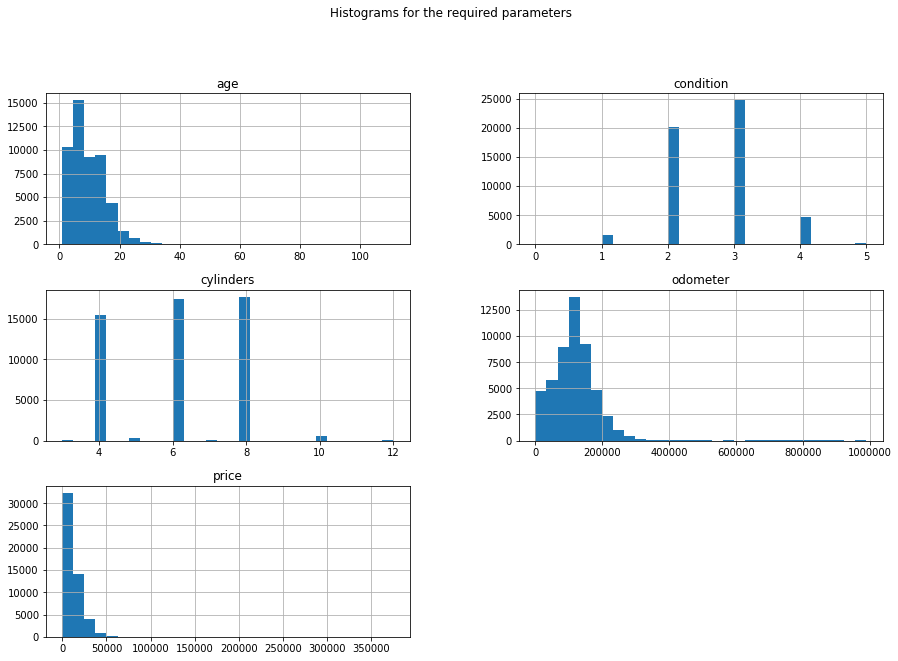

In [49]:
data[['age', 'condition', 'cylinders', 'odometer', 'price']].hist(bins = 30, figsize = (15, 10))
plt.suptitle('Histograms for the required parameters', y = 1);

Closer look at the price histogram:

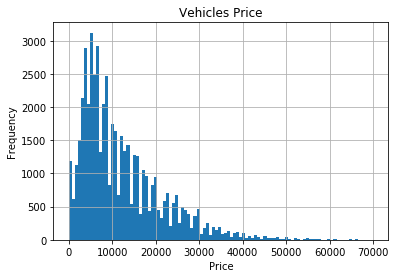

In [50]:
data['price'].hist(bins=100, range=[0, 70000])
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title("Vehicles Price");

Our price histogram is skewed to the right. The majority of the prices are in the price range of 1 to 30,000, with a long tail of high value prices. Histogram peaks at around 5000. The actual price range is between 1 to 375,000, with the mean at 12116 and median at 9000. Outliers significantly affect the readability of the histogram.

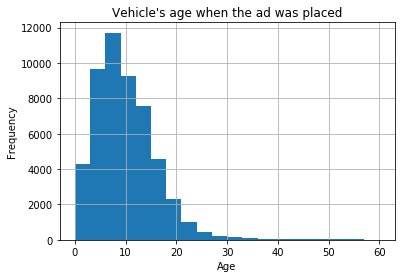

In [51]:
data['age'].hist(bins=20, range=[0, 60])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title("Vehicle's age when the ad was placed");

Histogram skewed right, same as the price histogram. The majority of vehicles ages are in the range of 1 to 20 years, with a long tail of higher value ages. The actual vehicle age range is between 1 to 111, with the mean at 9.5 and median at 9. Outliers significantly affect the readability of the histogram.

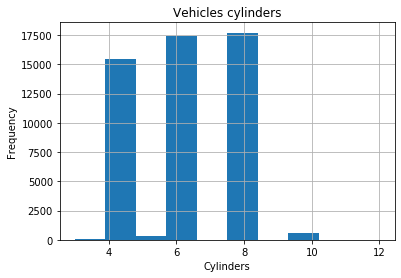

In [52]:
data['cylinders'].hist(bins=10)
plt.xlabel('Cylinders')
plt.ylabel('Frequency')
plt.title("Vehicles cylinders");

The histogram isn't skewed like before. The vast majority of vehicles cylinder is one of 4, 6, 8. We have some cards with less than 4 and some with more than 8,  and a little bit with 5, but overall those are negligible compared to the total amount. No visible outliers.

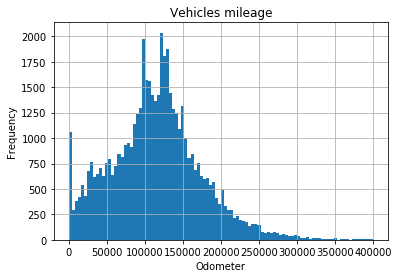

In [53]:
data['odometer'].hist(bins=100, range=[0, 400000])
plt.xlabel('Odometer')
plt.ylabel('Frequency')
plt.title("Vehicles mileage");

Histogram skewed right, same as the price histogram. The majority of vehicles mileage are in the range of 0 to 200,000, with a long tail of higher value ages. The actual vehicle mileage range is between 0 to 990000, with the mean at 115264 and median at 114677. Outliers significantly affect the readability of the histogram.

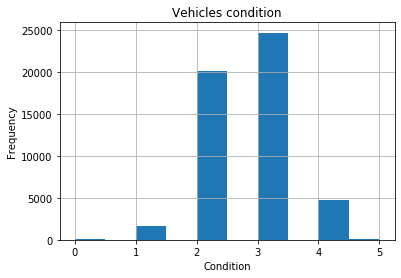

In [54]:
data['condition'].hist(bins=10)
plt.xlabel('Condition')
plt.ylabel('Frequency')
plt.title("Vehicles condition");

The histogram isn't skewed like before. The vast majority of vehicles condition is either excellent, or good. Only 6 total options, no outliers.

**Determine the upper limits of outliers, remove the outliers and store them in a separate DataFrame**

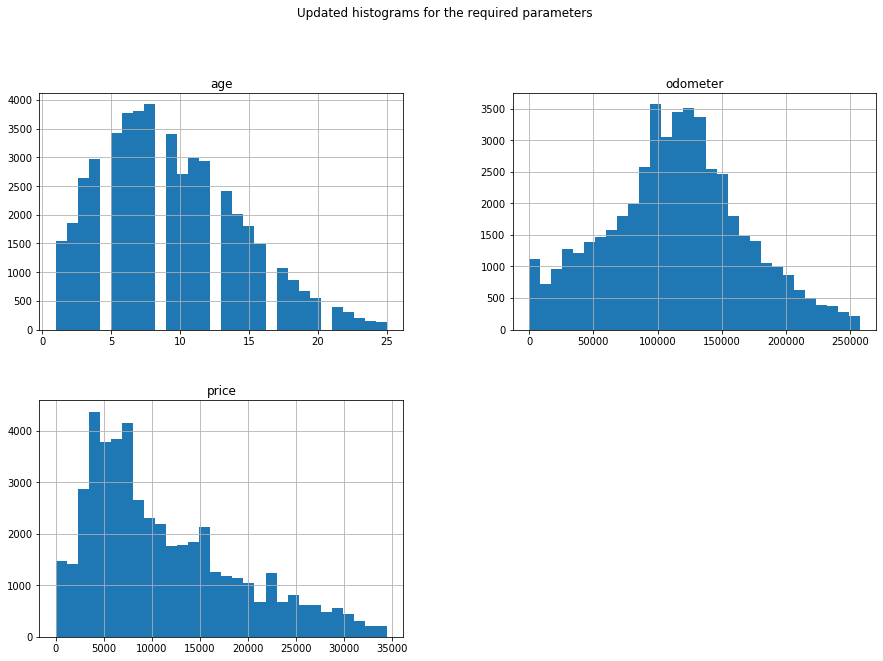

In [55]:
filtered_data = data[['age', 'condition', 'cylinders', 'odometer', 'price']]
Q1 = filtered_data.quantile(0.25)
Q3 = filtered_data.quantile(0.75)
IQR = Q3 - Q1
filtered_data = filtered_data[~((filtered_data < (Q1 - 1.5 * IQR)) |(filtered_data > (Q3 + 1.5 * IQR))).any(axis=1)]
filtered_data[['age', 'odometer', 'price']].hist(bins = 30, figsize = (15, 10))
plt.suptitle('Updated histograms for the required parameters', y = 1);

In [56]:
filtered_data.describe()

,age,condition,cylinders,odometer,price
count,48072.000000,48072.000000,48072.000000,48072.000000,48072.000000
mean,9.227617,2.637169,6.057414,113875.519762,11243.973290
std,5.045472,0.681031,1.656858,53415.361343,7819.053126
min,1.000000,1.000000,3.000000,0.000000,1.000000
25%,5.000000,2.000000,4.000000,79500.000000,5000.000000
50%,9.000000,3.000000,6.000000,115000.000000,8995.000000
75%,13.000000,3.000000,8.000000,147700.000000,15990.000000
max,25.000000,4.000000,12.000000,257500.000000,34500.000000


We had 3 columns with significant outliers: price, age and odometer. We can see that the new histograms are not skewed anymore. Using the describe function we can see that the outliers are no longer part of the dataset.
The extremely high max values for those columns are gone too. 

**Analyze how many days advertisements were displayed**

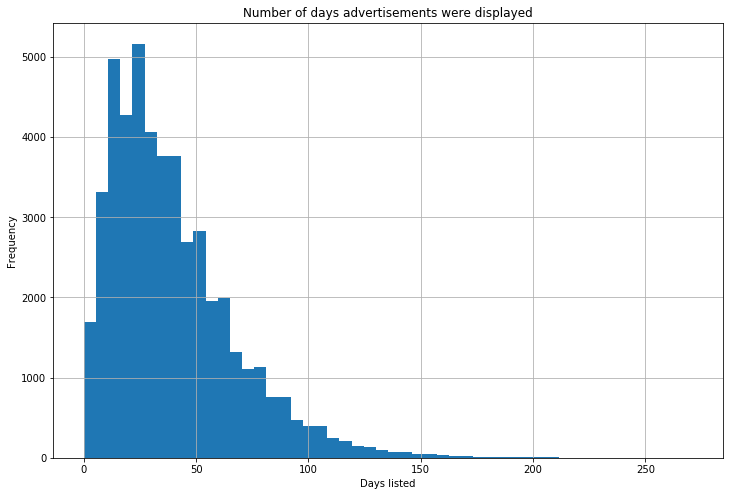

In [57]:
filtered_data["days_listed"] = data["days_listed"]
filtered_data["days_listed"].hist(bins=50, figsize=(12,8))
plt.xlabel('Days listed')
plt.ylabel('Frequency')
plt.title("Number of days advertisements were displayed");

**Our days_listed histogram is skewed to the right. The majority amount of listed days are in the range of 0 to 120, with a long tail, up to 271 days. Histogram peaks at around 30 days. The actual range is between 0 to 271 days, with the mean at 39.5 and median at 33.**

In [58]:
filtered_data["days_listed"].describe()

count    48072.000000
mean        39.548531
std         28.232082
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

In [59]:
print('The mean is {} days and the median is {} days'
      .format(round(filtered_data['days_listed'].mean(),0), round(filtered_data['days_listed'].median(),0)))

The mean is 40.0 days and the median is 33.0 days


Based on the histogram most ads were listed for 0 to 50 days. Based on that, the median and mean, the typical lifetime of an ad is around 1 month.

In [60]:
filtered_data.query('days_listed >= 120').shape

(801, 6)

In [61]:
filtered_data.query('days_listed <= 1').shape

(214, 6)

There are 214 ads that were listed for 1 day or less, meaning the vehicle been bought on the same or next day.
801 ads were listed for 4 months or more. 271 days is the most days ad was listed.

In [62]:
filtered_data.query('days_listed == 0').shape

(49, 6)

In [63]:
filtered_data[filtered_data['days_listed'] == 0].head(10)

,age,condition,cylinders,odometer,price,days_listed
1246,11,3,8,93300,14995,0
1981,20,3,8,137500,14000,0
2879,15,3,8,250000,4000,0
4561,12,2,4,223000,5000,0
4894,18,2,8,99892,12500,0
6106,16,1,6,215457,500,0
6540,12,2,6,152400,4800,0
7027,12,3,6,137252,5900,0
9597,8,3,4,125000,4999,0
9722,16,2,8,90048,15000,0


In [64]:
filtered_data[filtered_data['days_listed'] >= 120].head(10)

,age,condition,cylinders,odometer,price,days_listed
34,11,2,6,149799,9500,121
50,7,2,4,130323,3800,261
88,5,2,6,33926,18800,152
103,6,2,6,73711,22900,141
192,11,2,4,147000,6995,130
227,5,3,4,85452,8795,164
333,15,2,8,85104,13000,127
413,12,2,6,146000,7995,140
460,5,3,8,62500,27000,120
568,18,3,4,231089,7900,128


**There are 49 listings that ended in less than a day, which seems too abnormally quick for a vehicle to find a new buyer and there isn't a pattern for such vehicles. I assume that those specific cases were good deals hence sold in less than a day. On the other hand, 801 vehicles were listed for 4 months or more, which is abnormally long. Again, there is no pattern here. I can assume that for those vehicles the prices were abnormally expensive.**

**Analyze the number of ads and the average price for each type of vehicle**

In [65]:
filtered_data['type'] = data['type']
ad_type = filtered_data.pivot_table(index="type", 
                          values= ["price"], 
                          aggfunc =["count", 
                                    "mean"])
ad_type.columns= ["Ads", "Average price"]
ad_type.reset_index()

,type,Ads,Average price
0,SUV,11848,10453.884200
1,bus,23,17445.913043
2,convertible,350,12870.528571
3,coupe,2013,13496.071535
4,hatchback,997,6834.499498
5,mini-van,1137,8060.131926
6,offroad,182,14354.214286
7,other,234,10509.948718
8,pickup,6255,15077.672902
9,sedan,11920,6977.391359


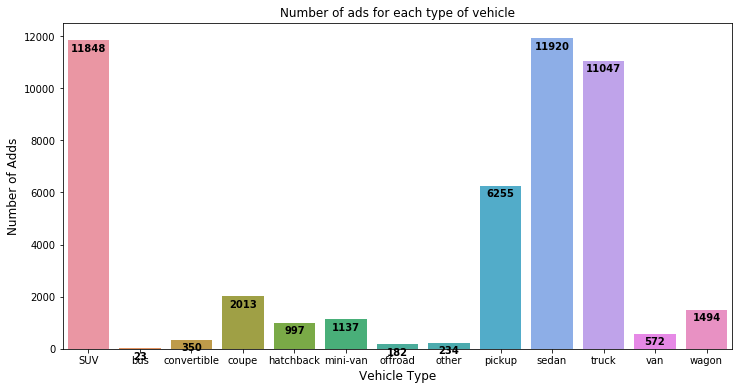

In [66]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
b_chart=sns.barplot(x=ad_type.index, y="Ads", data=ad_type, ax=ax, capsize=10)
plt.title("Number of ads for each type of vehicle",fontdict={"size":12})
plt.ylabel("Number of Adds", fontdict={"size":12})
plt.xlabel("Vehicle Type", fontdict={"size":12})
for p in b_chart.patches:
    b_chart.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext= (0, -8), 
                   textcoords = 'offset points', weight='bold')
plt.show()

In [67]:
ad_type.sort_values(by="Ads", ascending=False).index[0:2].tolist()

['sedan', 'SUV']

**The two types with the greatest number of ads are Sedan and SUV**. Bus type has the lowest amount ads but the highest mean price.

**What factors impact the price most?**

I'll study whether the price depends on age, mileage, condition, transmission type, and color. Let's start by adding transmission type and paint color to the filtered data:

In [68]:
filtered_data[["transmission", "paint_color"]] = data[["transmission", "paint_color"]]
filtered_data.head()

,age,condition,cylinders,odometer,price,days_listed,type,transmission,paint_color
0,8,2,6,145000,9400,19,SUV,automatic,other
1,9,2,6,88705,25500,50,pickup,automatic,white
2,7,4,4,110000,5500,79,sedan,automatic,red
3,17,1,8,124476,1500,9,pickup,automatic,other
4,3,3,4,80903,14900,28,sedan,automatic,black


Check whether transmission type and paint colors have at least 50 ads:

In [69]:
filtered_data["transmission"].value_counts()

automatic    43886
manual        2439
other         1747
Name: transmission, dtype: int64

In [70]:
filtered_data["paint_color"].value_counts()

white     9153
other     8668
black     7153
silver    5994
grey      4778
blue      4219
red       4069
green     1291
brown     1129
custom    1089
yellow     227
orange     213
purple      89
Name: paint_color, dtype: int64

Plotting box-and-whisker charts for transmission type and color:

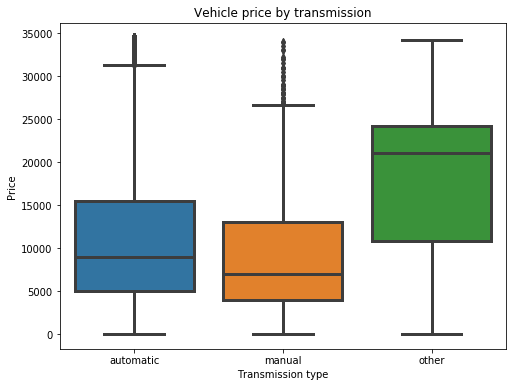

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
sns.boxplot(x="transmission", y="price", data = filtered_data, linewidth =3, ax=ax)
plt.title("Vehicle price by transmission")
plt.ylabel("Price")
plt.xlabel("Transmission type")
plt.show()



The box plot confirmed that transmission type is related to the vehicle price - the "other" transmission type prices are significantly higher compared to automatic and manual.

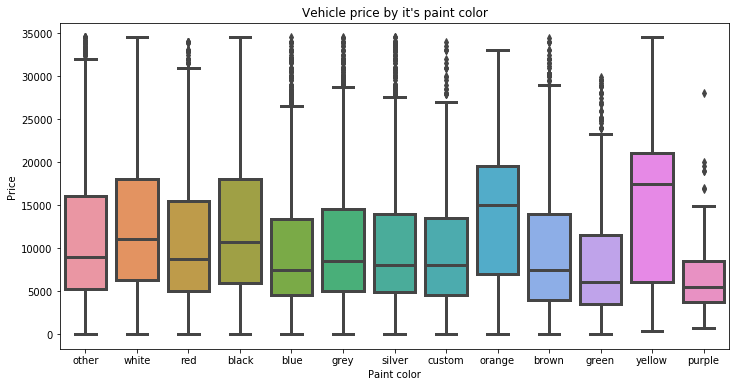

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.boxplot(x="paint_color", y="price", data = filtered_data, linewidth =3, ax=ax)
plt.title("Vehicle price by it's paint color")
plt.ylabel("Price")
plt.xlabel("Paint color")
plt.show()

The box plot confirmed that there is no clear difference in price based on the color. Both purple and orange color are a little bit pricier, but their general amount is negligible compared to the rest of the colors and not indicating on a trend (89 purple, 213 orange vehicles). The distribution of price between different paint colors have a significant overlap, the color won't be a good indicator for a vehicle price.

**Scatterplots for vehicle age, mileage, condition**

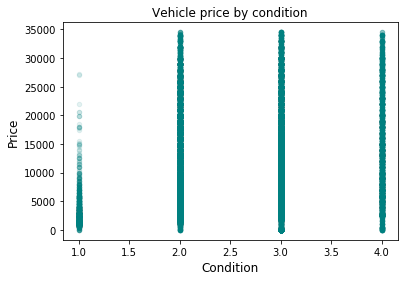

In [73]:
filtered_data.plot(y="price", x= "condition", color="teal", kind="scatter", alpha=.1)
plt.title("Vehicle price by condition",fontdict={"size":12})
plt.ylabel("Price", fontdict={"size":12})
plt.xlabel("Condition", fontdict={"size":12})
plt.show()


It's clear from the scatterplots that vehicles in a good condition or better prices are more expensive.

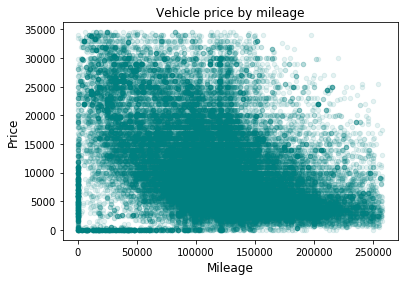

In [74]:
filtered_data.plot(y="price", x= "odometer", color= "teal", kind="scatter", alpha=.1)
plt.title("Vehicle price by mileage",fontdict={"size":12})
plt.ylabel("Price", fontdict={"size":12})
plt.xlabel("Mileage", fontdict={"size":12})
plt.show()

It's clear from the scatterplots more mileage equals cheaper vehicle.

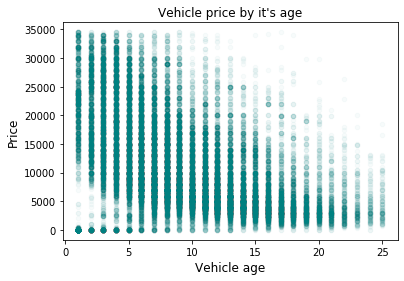

In [75]:
filtered_data.plot(y="price", x= "age", kind="scatter", color= "teal",alpha=.03)
plt.title("Vehicle price by it's age",fontdict={"size":12})
plt.ylabel("Price", fontdict={"size":12})
plt.xlabel("Vehicle age", fontdict={"size":12})
plt.show()

It's clear from the scatterplots older vehicle equals cheaper vehicle. 

## Overall conclusion

**Our main goal was to study data collected over the last few years and determine which factors influence the price of a vehicle, specifically vehicle age, paint color, transmission type, condition and the amount of mileage.**

We prepared the dataset so we could study it:
1. Removed or filled missing values in 5 columns.
2. Changed data type of 5 columns to more suitable ones for our analysis.
3. Made calculations and added 5 new columns to the dataset.
4. Changed condition column from strings to numeric values.

Now that we had clean dataset, we performed exploratory data analysis:
1. We plotted histograms for the parameters 'age', 'condition', 'cylinders', 'odometer', 'price', and studied how outliers affected each histogram readability. We found that the parameters 'age', 'odometer', 'price' were affected by outliers, skewed right. 
2. We removed the outliers and saved the filtered data in new DataFrame, plotted new histograms using the filtered data, studied each histogram and drew conclusions for each of the 5 parameters.
3. We plotted histogram for the parameter 'days_listed', studied the data and determined the typical lifetime of an ad (1 month). We also determined when ads were listed for too long or removed very quickly.
4. We plotted a graph showing dependence of the number of ads on the vehicle types. We found that Sedan and SUV had the most ads listed.
5. We plotted scatterplots or boxplots to each of age, mileage, condition, transmission type, and color, and determined if they had impact on the vehicle price. 

Those factors have significant impact on the vehicle price:
* Transmission type, other type (not manual or automatic) vehicles are significantly more expensive.
* Vehicle age impacts the price, newer vehicles are more expensive.
* Vehicle condition impacts the price - vehicles labeled in good condition or better are significantly more expensive compared to the lower tiers.
* Vehicle mileage impacts the price, more miles leads to cheaper vehicle.

More conclusions:

* Vehicle paint color doesn't impact the price significantly.

* Sedan and SUV are the most popular vehicle types in the Crankshaft List.

* The average selling window of a vehicle is around 1 month. Vehicles can get sold in the same day as listed or not at all in a very long time.

* Outliers in the dataset have significant impact on it's readability.

# Project completion checklist

Mark the completed tasks with 'x'. Then press Shift+Enter.

- [x]  file opened
- [x]  files explored (first rows printed, info() method)
- [x]  missing values determined
- [x]  missing values filled in
- [x]  clarification of the discovered missing values provided
- [x]  data types converted
- [x]  explanation of which columns had the data types changed and why
- [x]  calculated and added to the table: day of the week, month, and year the ad was placed
- [x]  calculated and added to the table: the vehicle's age (in years) when the ad was placed
- [x]  calculated and added to the table: the vehicle's average mileage per year
- [x]  the following parameters investigated: price, vehicle's age when the ad was placed, mileage, number of cylinders, and condition
- [x]  histograms for each parameter created
- [x]  task completed: "Determine the upper limits of outliers, remove the outliers and store them in a separate DataFrame, and continue your work with the filtered data."
- [x]  task completed: "Use the filtered data to plot new histograms. Compare them with the earlier histograms (the ones that included outliers). Draw conclusions for each histogram."
- [x]  task completed: "Study how many days advertisements were displayed (days_listed). Plot a histogram. Calculate the mean and median. Describe the typical lifetime of an ad. Determine when ads were removed quickly, and when they were listed for an abnormally long time.  "
- [x]  task completed: "Analyze the number of ads and the average price for each type of vehicle. Plot a graph showing the dependence of the number of ads on the vehicle type. Select the two types with the greatest number of ads. "
- [x]  task completed: "What factors impact the price most? Take each of the popular types you detected at the previous stage and study whether the price depends on age, mileage, condition, transmission type, and color. For categorical variables (transmission type and color), plot box-and-whisker charts, and create scatterplots for the rest. When analyzing categorical variables, note that the categories must have at least 50 ads; otherwise, their parameters won't be valid for analysis.  "
- [x]  each stage has a conclusion
- [x]  overall conclusion drawn